<a href="https://colab.research.google.com/github/Parthbisht16/Lung_Cancer_Detection_minor_project/blob/main/lung_cancer_detection_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from zipfile import ZipFile

data_path = 'lung_colon_image_set.zip'

with ZipFile(data_path,'r') as zip:
    zip.extractall()
    print('The data set has been extracted.')


The data set has been extracted.


In [ ]:
path = 'lung_image_sets'
classes = os.listdir(path)
classes

['lung_aca', 'lung_n', 'lung_scc']

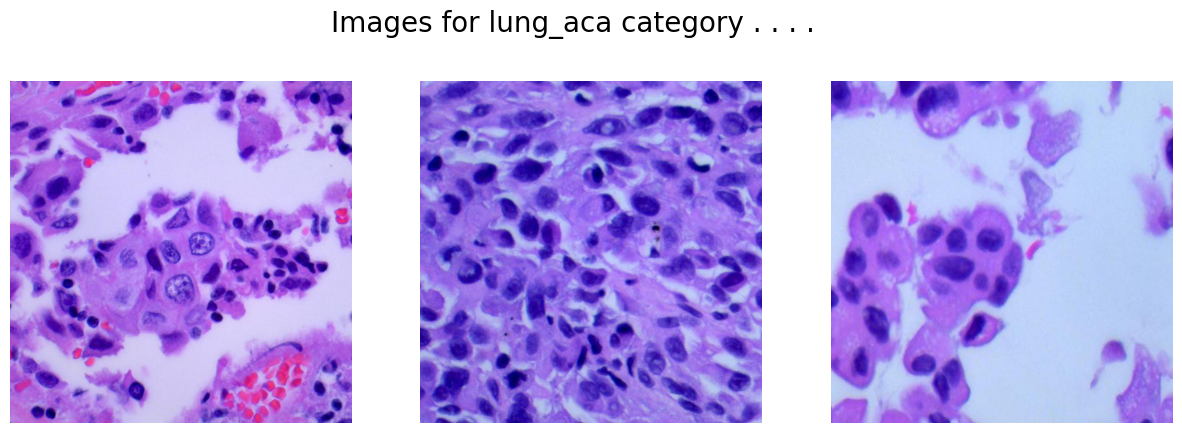

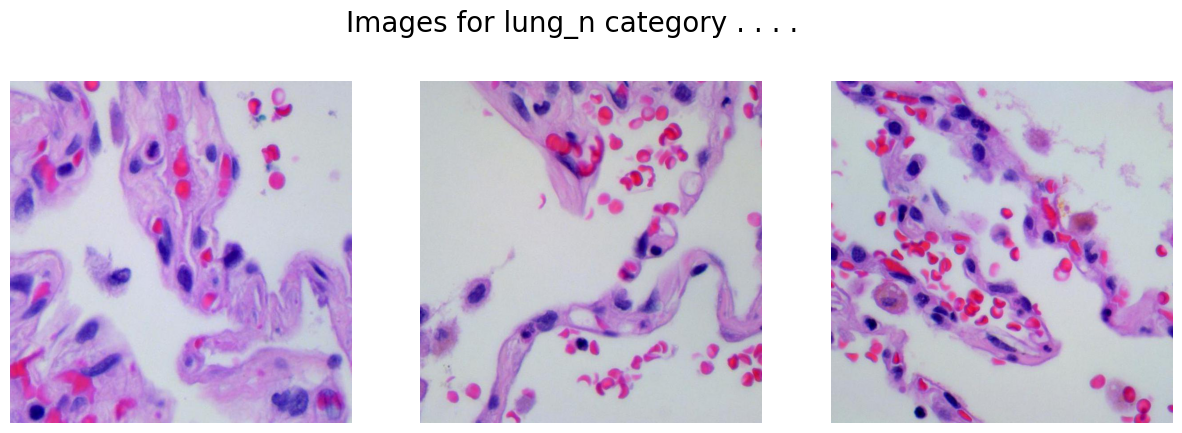

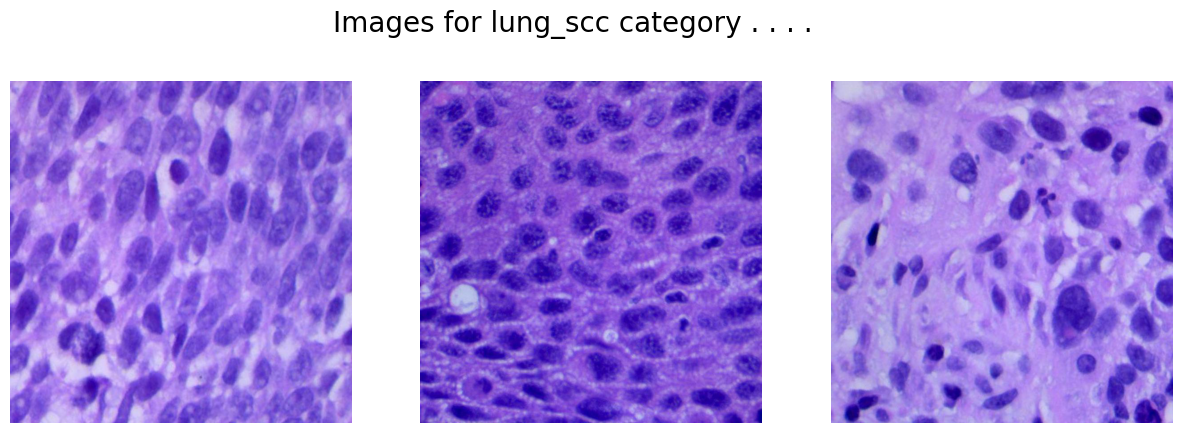

In [ ]:
path = 'lung_image_sets'

for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)

    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()


In [ ]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 8
BATCH_SIZE = 64

In [ ]:
X = []
Y = []

for i, cat in enumerate(classes):
    images = glob(f'{path}/{cat}/*.jpeg')

    for image in images:
        img = cv2.imread(image)

        X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
        Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y,test_size = SPLIT,random_state = 2022)
print(X_train.shape, X_val.shape)


(12000, 256, 256, 3) (3000, 256, 256, 3)


In [ ]:
from keras.applications import MobileNetV2

base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False)
base_model.trainable = False

model = keras.models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(3, activation='softmax')
])

In [ ]:
model.compile(
	optimizer = 'adam',
	loss = 'categorical_crossentropy',
	metrics = ['accuracy']
)

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if logs.get('val_accuracy') > 0.80:
			print('\n Validation accuracy has reached upto \
					80% so, stopping further training.')
			self.model.stop_training = True


es = EarlyStopping(patience=2,
				monitor='val_accuracy',
				restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss',
					patience=2,
					factor=0.5,
					verbose=1)

In [ ]:
history = model.fit(X_train, Y_train,
					validation_data = (X_val, Y_val),
					batch_size = BATCH_SIZE,
					epochs = EPOCHS,
					verbose = 1,
					callbacks = [es, lr, myCallback()])

Epoch 1/8
188/188 ━━━━━━━━━━━━━━━━━━━━ 561s 3s/step - accuracy: 0.8709 - loss: 0.3124 - val_accuracy: 0.4323 - val_loss: 1.0161 - learning_rate: 0.0010
Epoch 2/8
188/188 ━━━━━━━━━━━━━━━━━━━━ 534s 3s/step - accuracy: 0.9152 - loss: 0.2064 - val_accuracy: 0.6497 - val_loss: 1.5552 - learning_rate: 0.0010
Epoch 3/8
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9137 - loss: 0.2001
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
188/188 ━━━━━━━━━━━━━━━━━━━━ 535s 3s/step - accuracy: 0.9137 - loss: 0.2001 - val_accuracy: 0.3780 - val_loss: 4.2036 - learning_rate: 0.0010
Epoch 4/8
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9203 - loss: 0.1882
 Validation accuracy has reached upto 					80% so, stopping further training.
188/188 ━━━━━━━━━━━━━━━━━━━━ 535s 3s/step - accuracy: 0.9203 - loss: 0.1882 - val_accuracy: 0.9193 - val_loss: 0.1809 - learning_rate: 5.0000e-04


In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)  │ (None, 8, 8, 1280)            │   2,257,984 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ global_average_pooling2d_2         │ (None, 1280)                  │           0 │
│ (GlobalAveragePooling2D)           │                               │             │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_9 (Dense)                    │ (None, 256)                   │     327,936 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ batch_normalization_6              │ (None, 256)                   │       1,024 │
│ (BatchNormalization)               │                               │             │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout_3 (Dropout)                │ (None, 256)                   │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_10 (Dense)                   │ (None, 128)                   │      32,896 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ batch_normalization_7              │ (None, 128)                   │         512 │
│ (BatchNormalization)               │                               │             │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_11 (Dense)                   │ (None, 3)                     │         387 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 3,344,715 (12.76 MB)

 Trainable params: 361,987 (1.38 MB)

 Non-trainable params: 2,258,752 (8.62 MB)

 Optimizer params: 723,976 (2.76 MB)

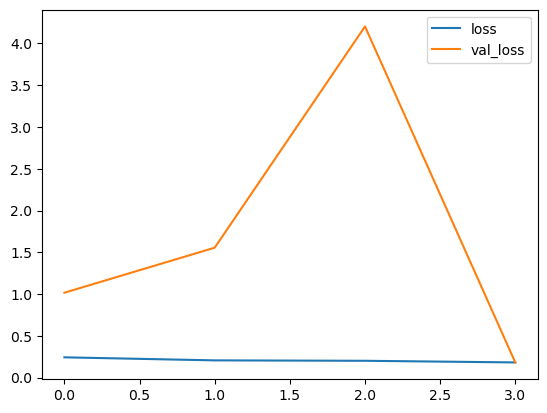

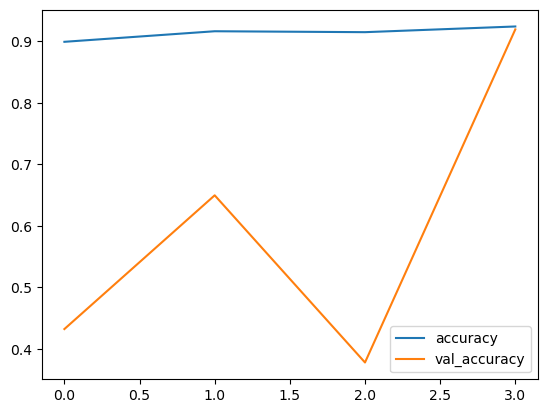

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

In [ ]:
Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step


In [ ]:
metrics.confusion_matrix(Y_val, Y_pred)

array([[891,  24,  72],
       [  5, 972,   0],
       [141,   0, 895]], dtype=int64)

In [ ]:
print(metrics.classification_report(Y_val, Y_pred,
									target_names=classes))

              precision    recall  f1-score   support

    lung_aca       0.86      0.90      0.88       987
      lung_n       0.98      0.99      0.99       977
    lung_scc       0.93      0.86      0.89      1036

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



In [ ]:
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input

def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img/255.0
    return np.asarray(img)

In [ ]:
img_path = 'lung_image_sets/lung_n/lungn1501.jpeg'
preprocessed_img = preprocess_image(img_path)
# Ensure batch dimension
preprocessed_img = np.expand_dims(preprocessed_img, axis=0)
# Get model predictions
predictions = model.predict(preprocessed_img)
# Convert predictions to class labels
predicted_class = np.argmax(predictions, axis=1)
print(f'The predicted class is: {classes[predicted_class[0]]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
The predicted class is: lung_n
